# Naive Bayes Classifier

## Import the libraries

In [44]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

## Incredibly naive NB

### Loading the data and exploring its structure

We load the data from the 'data.json' file, which is part of the Wizard of Wikipedia dataset.

In [45]:
data_path = 'wizard_of_wikipedia/data.json'

with open(data_path, 'r') as f:
    data = json.load(f)

We can see that the dataset we just loaded is a list of objects, each of which corresponds to a single dialogue, characterized by 5 attributes:

In [46]:
print(data[0].keys())

dict_keys(['chosen_topic', 'persona', 'wizard_eval', 'dialog', 'chosen_topic_passage'])


In [47]:
data[0]

{'chosen_topic': 'Science fiction',
 'persona': 'i enjoy movies about aliens invading the earth.',
 'wizard_eval': 5,
 'dialog': [{'speaker': '0_Wizard',
   'text': "I think science fiction is an amazing genre for anything. Future science, technology, time travel, FTL travel, they're all such interesting concepts.",
   'checked_sentence': {'chosen_Science_fiction_0': 'Science fiction (often shortened to SF or sci-fi) is a genre of speculative fiction, typically dealing with imaginative concepts such as futuristic science and technology, space travel, time travel, faster than light travel, parallel universes, and extraterrestrial life.'},
   'checked_passage': {'chosen_topic_0_Science_fiction': 'Science fiction'},
   'retrieved_passages': [{'Hyperspace (science fiction)': ['Hyperspace is a faster-than-light (FTL) method of traveling used in science fiction.',
      'It is typically described as an alternative "sub-region" of space co-existing with our own universe which may be entered u

In [48]:
print(f'There are {len(data)} dialogues in the dataset')

There are 22311 dialogues in the dataset


The goal in this notebook is to train a Naive Bayes classifier, which means that the only things we need are the chosen topic of the conversation (the target, which the classifier will need to output after the training) and the text of teh dialogue.

The following code snippet extracts what we need from the complete dataset:

In [49]:
dialogues = []
topics = []
for i in range(len(data)):
    text = []
    for j in range(len(data[i]['dialog'])):
        text.append(data[i]['dialog'][j]['text'])
    dialogues.append('\n'.join(text))
    topics.append(data[i]['chosen_topic'])

Here's a sample of the extraction:

In [50]:
print(f'{topics[1]}\n')
print(dialogues[1])

Internet access

Can you imagine the world without internet access? 
No I could not! I couldn't imagine living when internet access was rare and very few people had it!
Oh me either! It seems like such a long time ago. I wonder when Internet was first created?
It used to be restricted, but around 1995, the restricted were lifted and commercial use of it began
That is awesome. I wonder why it was restricted? Probably because they only wanted government and big companies to use it at first.
Yes, it was developed from a government funded projects to help with universities research and laboratories in the United States...I am so glad they expanded it! 
I am too, it makes life so much easier!
What is your favorite thing to do with internet access? I like being able to use my computer and smartphone to use my email and browse the world wide web


### Training and evaluating the classifier

We use the train_test_split function from Scikit-Learn to separate the dataset into training and testing data, with a ratio of 80:20

In [51]:
# Apply train_test_split to both dialogues and topics, maintaining the connection between the two
train_dialogues, test_dialogues, train_topics, test_topics = train_test_split(dialogues, topics, test_size=0.2, random_state=42)

**Scikit-Learn is the MVP of this notebook.**

We now use it to create a pipeline for the data: first, the TfidfVectorizer converts each dialogue into a set of its td-idf features, which are then passed to the MultinomialNB, used for multi-class classification.

In [52]:
# Model building
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

# Training the model with the training data
model.fit(train_dialogues, train_topics)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

The training is done, so it's time to test out model:

In [53]:
# Predicting the test data categories
predicted_categories = model.predict(test_dialogues)

And print out some of the results:

In [54]:
print(predicted_categories)

['Parenting' 'Pizza' 'Pizza' ... 'Pizza' "McDonald's" 'Night owl (person)']


It seems like there might be a lot of 'Pizza' predictions... let's look at some metrics to get an idea of our model's performance:

In [55]:
# Print the accuracy, precision, recall and F1 scores
print(f'Accuracy:  {accuracy_score(test_topics, predicted_categories)}')
print(f'Precision: {precision_score(test_topics, predicted_categories, average="macro", zero_division=0)}')
print(f'Recall:    {recall_score(test_topics, predicted_categories, average="macro")}')
print(f'F1 Score:  {f1_score(test_topics, predicted_categories, average="macro")}')

Accuracy:  0.1382478153708268
Precision: 0.04820681161108527
Recall:    0.022997999279340185
F1 Score:  0.02580491769033291


This is quite disappointing: while it's true that there are a lot of unique topics, all the scores are way too low.

Let's explore the dataset a bit more:

In [56]:
print(f'The number of unique conversation topics is: {len(set(topics))}\n')
print(f'Number of training samples: {len(train_topics)}')
print(f'Number of testing samples:  {len(test_topics)}')


The number of unique conversation topics is: 1365

Number of training samples: 17848
Number of testing samples:  4463


We noticed before that there seemed to be a lot of 'Pizza' predictions: how many are there? Is there a correlation between that and the low metrics' scores?

In [57]:
# Get the number of Pizza predictions
pizza_predictions = predicted_categories[predicted_categories == 'Pizza']
print(f'The number of \'Pizza\' predictions is: {len(pizza_predictions)}')

The number of 'Pizza' predictions is: 3553


That's definitely a lot, especially considering the size of the testing data!

Could all the mispredictions be 'Pizza' ones?

In [58]:
# Find the correct predictions
correct = np.where(predicted_categories==test_topics, 1, 0)

# Get the indices of the correct predictions
correct_indices = np.where(correct==1)[0]
print(f'The number of correct predictions is: {len(correct_indices)}')
print(f'The number of incorrect predictions is: {len(predicted_categories) - len(correct_indices)}')

The number of correct predictions is: 617
The number of incorrect predictions is: 3846


It seems not. Still, the 'Pizza' mispredictions are a large part of them.

Let's find out the unique misprediction guesses:

In [59]:
# Get unique mispredictions
unique_mistakes = []
for i in range(len(predicted_categories)):
    if predicted_categories[i] != test_topics[i] and predicted_categories[i] not in unique_mistakes:
        unique_mistakes.append(predicted_categories[i])
print(f'The number of unique mistakes is: {len(unique_mistakes)}')
print(unique_mistakes)

The number of unique mistakes is: 19
['Pizza', 'Cat', 'Reading (process)', 'Blue', 'Dog', 'Yoga', 'Veganism', 'Red hair', 'The Beatles', 'Parenting', 'Hiking', 'Swimming', 'Game of Thrones', 'Heavy metal music', 'The Rolling Stones', 'Ice hockey', 'New York City', 'Guitar', 'Association football']


Let's try writing a dialogue on something completely unrelated to food:

In [60]:
# Write a dialog on politics
input = ['I think that the government should invest more in education and healthcare.', 'I agree with you.', 'I think that the government should lower taxes.', 'But if they lower taxes, where will they find the money to invest in education and healthcare?']
predicted_category = model.predict(input)[0]
print("You're talking about: " + predicted_category)

You're talking about: Pizza


We brought up a starving classifier...

We can see that a very small number of topics covers all the misprediction guesses: checking the number of dialogues per topic in the dataset might be a good idea:

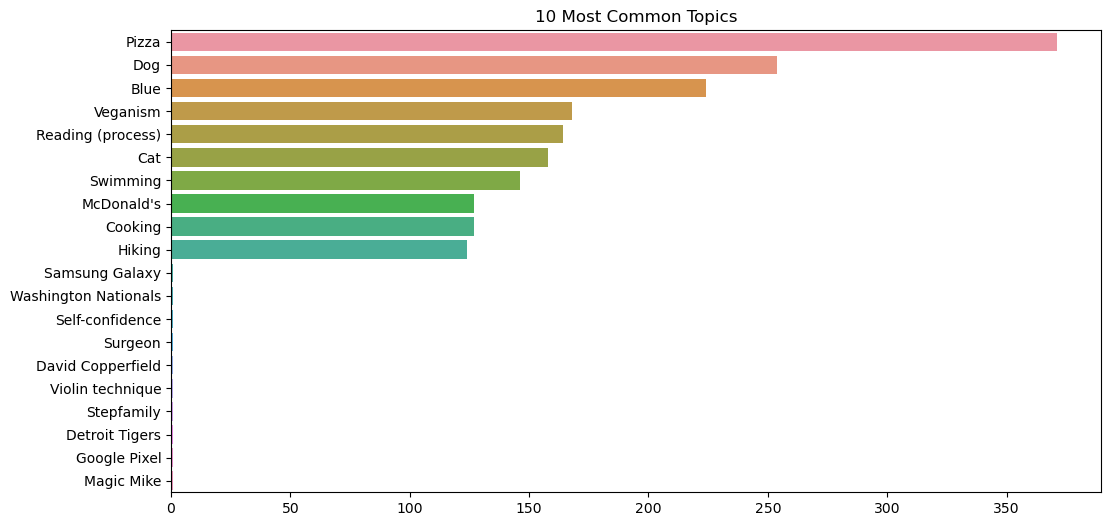

In [61]:
# Plot the 10 most common topics and the least 10 common topics, on the same graph
most_common = pd.value_counts(topics).iloc[:10]
least_common = pd.value_counts(topics).iloc[-10:]
topics_to_plot = pd.concat([most_common, least_common])

plt.figure(figsize=(12, 6))
sns.barplot(y=topics_to_plot.index, x=topics_to_plot.values)
plt.title('10 Most Common Topics')
plt.show()

This explains the behavior of the model and the low scores: since Naive Bayes learns probabililty distributions, a big difference in the number of samples between the classes adds a non-negligible bias to the model.

### Some dialogues and their predictions

In [62]:
print(f'The first correct predictions are at indices: {correct_indices[:5]}')

The first correct predictions are at indices: [ 0  4  6  7 31]


In [63]:
# A correct dialogue prediction
print(test_topics[0] + ' --> ' + predicted_categories[0] + '\n')
print(test_dialogues[0])

Parenting --> Parenting

I have a seven year old daughter. She is my everything!
Parenting is all about promoting and supporting child growth
It certainly is.  Those early years are the most important.
yea Parenting  required a lot of emotional and physical support
It really helps to have both parents to take the load off each other.
Parenting and raisiing a child is a very hard process tho
Tell me about it.  Once they start going to school it gets slightly easier.
im not one myself but i can imagine its quite the task when they are babies


In [64]:
# A mispredicted dialogue
print(test_topics[1] + ' --> ' + predicted_categories[1] + '\n')
print(test_dialogues[1])

Motorcycle club --> Pizza

I am in a motorcycle club.
When do they do in a motorcyle club?
We organize around a type of riding.
When was the first of such clubs started  in history
I have no clue but my motorcycle club has elected officers.
Which country has more of such clubs?
I am not sure but there are specific clubs for women also.
does the   number of motorcycle factories in a place influence the availability of the clubs?
I am not sure but there are specific clubs for women also.


In [65]:
# A somewhat correct dialogue prediction
print(test_topics[9] + ' --> ' + predicted_categories[9] + '\n')
print(test_dialogues[9])

Science fiction --> Reading (process)

I really enjoy science fiction. Books, movies, anything! I always find it fascinating.
Me too! I love how science fiction often explores the consequences of potential innovations. Such as robots taking over the world.
Yeah, I think it's very good food for thought. Sometimes science fiction becomes reality! 
Yeah, a lot of technology that has been created has actually been based on science fiction novels.For example humans created robots, which are programmable by computer and capable of carrying out complex actions to help make certain jobs easier.
Science fiction
I also like how sci-fi avoids the genre of supernatural and are more realistic 
Very fascinating! I bet we've been making science fiction for a very long time. Ever since we can think abstractly!
Science fictions stories are also often grounded in actual theories so it is a lot more believable than a lot of other novels. 
Yeah, I'm personally not a fan of anything supernatural! Though so

## Better NB

### Data preprocessing

The last attempt failed because we did not prepare the dataset well enough, so let's try to bring each topic to have a similar amount of samples.

In [66]:
with open('wizard_of_wikipedia/data.json', 'r') as f:
    data = json.load(f)

In [67]:
dialogues = []
topics = []
for i in range(len(data)):
    text = []
    for j in range(len(data[i]['dialog'])):
        text.append(data[i]['dialog'][j]['text'])
    dialogues.append('\n'.join(text))
    topics.append(data[i]['chosen_topic'])

In [68]:
# Count the number of dialogues per topic
topic_counts = {}
for topic in topics:
    if topic not in topic_counts:
        topic_counts[topic] = 1
    else:
        topic_counts[topic] += 1

# Print the topic counts ordered by count
print(sorted(topic_counts.items(), key=lambda x: x[1], reverse=True))

[('Pizza', 371), ('Dog', 254), ('Blue', 224), ('Veganism', 168), ('Reading (process)', 164), ('Cat', 158), ('Swimming', 146), ('Cooking', 127), ("McDonald's", 127), ('Hiking', 124), ('New York City', 121), ('Parenting', 115), ('Vegetarianism', 115), ('Surfing', 110), ('Divorce', 107), ('Red', 107), ('Green', 101), ('Steak', 98), ('Red hair', 95), ('Yoga', 94), ('Chocolate', 92), ('Animal shelter', 89), ('Heavy metal music', 85), ('Beach', 85), ('Armadillo', 84), ('Taco', 84), ('Piano', 82), ('Night owl (person)', 82), ('Sushi', 81), ('Florida', 81), ('Game of Thrones', 76), ('Guitar', 74), ('Country music', 74), ('Golden Retriever', 73), ('The Beatles', 73), ('Purple', 72), ('Ice cream', 71), ('Association football', 70), ('Video game', 70), ('Italian cuisine', 69), ('Pasta', 69), ('Dance', 68), ('Gardening', 68), ('Drawing', 66), ('Yellow', 65), ('Husky', 64), ('Honda Civic', 64), ('Skateboarding', 63), ('Rose', 62), ('Hamburger', 60), ('The Rolling Stones', 60), ('Basketball', 59), (

In [69]:
# Print the average topic count
print(f'The average number of dialogues per topic is: {sum(topic_counts.values()) / len(topic_counts):.2f}')

The average number of dialogues per topic is: 16.35


We can now better see how uneven the distribution of samples is.

Let's set upper and lower bounds to the number of dialogues: since the average number of dialogues is around 16, we'll only keep the topics with at least 10 dialogues, and limit the number of samples to 20 for topics with more than that.

In [70]:
# Only keep the dialogues and categories with a count of at least 10
new_dialogues = []
new_topics = []
for i in range(len(dialogues)):
    if topic_counts[topics[i]] >= 10:
        # Append the dialogues and categories if there are not already 20 of the same category in new_topics
        if new_topics.count(topics[i]) < 20:
            new_dialogues.append(dialogues[i])
            new_topics.append(topics[i])

In [71]:
# Print the topic counts ordered by count
new_topic_counts = {}
for topic in new_topics:
    if topic not in new_topic_counts:
        new_topic_counts[topic] = 1
    else:
        new_topic_counts[topic] += 1

print(f'The new number of topics is: {len(new_topic_counts)}')
print(sorted(new_topic_counts.items(), key=lambda x: x[1], reverse=True))

The new number of topics is: 715
[('Science fiction', 20), ('Homebrewing', 20), ('Red hair', 20), ('Bank teller', 20), ('Parachuting', 20), ('The Hershey Company', 20), ('Divorce', 20), ('Chevrolet Corvette', 20), ('Fly fishing', 20), ('Skateboarding', 20), ('Burrito', 20), ('Piano', 20), ('Snake', 20), ('Cat', 20), ('Pizza', 20), ('Dating', 20), ('Blue', 20), ('Hitchhiking', 20), ('Vermont', 20), ('Beer', 20), ('Marathon', 20), ('South Park', 20), ("Grey's Anatomy", 20), ('Dragon', 20), ('Hiking', 20), ('Bible', 20), ('Track and field', 20), ('Giant panda', 20), ('Pet', 20), ('Sushi', 20), ('New York City', 20), ('Dance', 20), ('Seattle', 20), ('Traffic collision', 20), ('Reading (process)', 20), ('Comic book', 20), ('Honda', 20), ('Gardening', 20), ('Rita Hayworth', 20), ('Steak', 20), ('List of orphans and foundlings', 20), ('Onion', 20), ('Beard', 20), ('Washington Wizards', 20), ('Homeschooling', 20), ('Kayaking', 20), ('Ice hockey', 20), ('EuroBasket', 20), ('Hockey', 20), ('Lond

We can see how the number of classes has been halved: this is unfortunate, but topics with too few samples would only bring disadvantages to the model.

We can also see how the number of samples per class is now bounded between 10 and 20.

### Training and evaluating the classifier

Since there are no more topics with only one dialogue, we can now use the 'stratify' parameter of the train_test_split function, which separates the samples for each class into the training and testing data according to the set ratio:

In [72]:
# Apply train_test_split to both dialogues and topics, maintaining the connection between the two
train_dialogues_2, test_dialogues_2, train_topics_2, test_topics_2 = train_test_split(new_dialogues, new_topics, test_size=0.2, random_state=42, stratify=new_topics)

In [73]:
# Model building
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

# Training the model with the training data
model.fit(train_dialogues_2, train_topics_2)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [74]:
# Predicting the test data categories
predicted_categories_2 = model.predict(test_dialogues_2)

Let's test the model and see if we managed to improve its prediction capabilities:

In [75]:
# Print the accuracy, precision, recall and F1 scores
print(f'Accuracy:  {accuracy_score(test_topics_2, predicted_categories_2)}')
print(f'Precision: {precision_score(test_topics_2, predicted_categories_2, average="macro", zero_division=0)}')
print(f'Recall:    {recall_score(test_topics_2, predicted_categories_2, average="macro")}')
print(f'F1 Score:  {f1_score(test_topics_2, predicted_categories_2, average="macro")}')

Accuracy:  0.8022249690976514
Precision: 0.7646812961251463
Recall:    0.7519813519813521
F1 Score:  0.7321819284057047


This is way better! It seems the issue was indeed the uneven distribution of samples.

What if we bring this to the extreme and set all topics to have the same number of dialogues?

## Evenly Trained NB

### Data preprocessing

In order to be able to best compare this new model to the previous one, we'll keep the same number of classes, which means both the upper and lower bound for the number of dialogues per topic will be set to 10.

In [76]:
with open('wizard_of_wikipedia/data.json', 'r') as f:
    data = json.load(f)

In [77]:
dialogues = []
topics = []
for i in range(len(data)):
    text = []
    for j in range(len(data[i]['dialog'])):
        text.append(data[i]['dialog'][j]['text'])
    dialogues.append('\n'.join(text))
    topics.append(data[i]['chosen_topic'])

In [78]:
# Count the number of dialogues per topic
topic_counts = {}
for topic in topics:
    if topic not in topic_counts:
        topic_counts[topic] = 1
    else:
        topic_counts[topic] += 1

# Print the topic counts ordered by count
print(sorted(topic_counts.items(), key=lambda x: x[1], reverse=True))

[('Pizza', 371), ('Dog', 254), ('Blue', 224), ('Veganism', 168), ('Reading (process)', 164), ('Cat', 158), ('Swimming', 146), ('Cooking', 127), ("McDonald's", 127), ('Hiking', 124), ('New York City', 121), ('Parenting', 115), ('Vegetarianism', 115), ('Surfing', 110), ('Divorce', 107), ('Red', 107), ('Green', 101), ('Steak', 98), ('Red hair', 95), ('Yoga', 94), ('Chocolate', 92), ('Animal shelter', 89), ('Heavy metal music', 85), ('Beach', 85), ('Armadillo', 84), ('Taco', 84), ('Piano', 82), ('Night owl (person)', 82), ('Sushi', 81), ('Florida', 81), ('Game of Thrones', 76), ('Guitar', 74), ('Country music', 74), ('Golden Retriever', 73), ('The Beatles', 73), ('Purple', 72), ('Ice cream', 71), ('Association football', 70), ('Video game', 70), ('Italian cuisine', 69), ('Pasta', 69), ('Dance', 68), ('Gardening', 68), ('Drawing', 66), ('Yellow', 65), ('Husky', 64), ('Honda Civic', 64), ('Skateboarding', 63), ('Rose', 62), ('Hamburger', 60), ('The Rolling Stones', 60), ('Basketball', 59), (

In [79]:
# Only keep the dialogues and categories with a count of at least 10
new_dialogues = []
new_topics = []
for i in range(len(dialogues)):
    if topic_counts[topics[i]] >= 10:
        # Append the dialogues and categories if there are not already 10 of the same category in new_topics
        if new_topics.count(topics[i]) < 10:
            new_dialogues.append(dialogues[i])
            new_topics.append(topics[i])

In [80]:
# Print the topic counts ordered by count
new_topic_counts = {}
for topic in new_topics:
    if topic not in new_topic_counts:
        new_topic_counts[topic] = 1
    else:
        new_topic_counts[topic] += 1

print(f'The new number of topics is: {len(new_topic_counts)}')
print(sorted(new_topic_counts.items(), key=lambda x: x[1], reverse=True))

The new number of topics is: 715
[('Science fiction', 10), ('Internet access', 10), ('Pharmacist', 10), ('Homebrewing', 10), ('Red hair', 10), ('Romance (love)', 10), ('Krav Maga', 10), ('Bank teller', 10), ('Parachuting', 10), ('Thursday', 10), ('The Hershey Company', 10), ('Divorce', 10), ('Chevrolet Corvette', 10), ('Kindergarten', 10), ('Aquarium', 10), ('Fly fishing', 10), ('My Little Pony', 10), ('Skateboarding', 10), ('Burrito', 10), ('Piano', 10), ('Scotch whisky', 10), ('Snake', 10), ('Cat', 10), ('Pizza', 10), ('Dating', 10), ('Blue', 10), ('Hitchhiking', 10), ('Vermont', 10), ('Beer', 10), ('Marathon', 10), ('Artist', 10), ('South Park', 10), ("Grey's Anatomy", 10), ('Dragon', 10), ('Hiking', 10), ('Bible', 10), ('Track and field', 10), ('Giant panda', 10), ('Pet', 10), ('Sushi', 10), ('Goodfellas', 10), ('New York City', 10), ('Dance', 10), ('Unemployment', 10), ('Sport utility vehicle', 10), ('Seattle', 10), ('Mystery film', 10), ('Traffic collision', 10), ('Reading (proce

Good, now all the classes have the same number of samples (and we have the same number of classes as before).

Let's go on to the training.

### Training and evaluating the classifier

In [81]:
# Apply train_test_split to both dialogues and topics, maintaining the connection between the two
train_dialogues_3, test_dialogues_3, train_topics_3, test_topics_3 = train_test_split(new_dialogues, new_topics, test_size=0.2, random_state=42, stratify=new_topics)

In [82]:
# Model building
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

# Training the model with the training data
model.fit(train_dialogues_3, train_topics_3)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [83]:
# Predicting the test data categories
predicted_categories_3 = model.predict(test_dialogues_3)

In [84]:
# Print the accuracy, precision, recall and F1 scores
print(f'Accuracy:  {accuracy_score(test_topics_3, predicted_categories_3)}')
print(f'Precision: {precision_score(test_topics_3, predicted_categories_3, average="macro", zero_division=0)}')
print(f'Recall:    {recall_score(test_topics_3, predicted_categories_3, average="macro")}')
print(f'F1 Score:  {f1_score(test_topics_3, predicted_categories_3, average="macro")}')

Accuracy:  0.8972027972027972
Precision: 0.9114219114219114
Recall:    0.8972027972027972
F1 Score:  0.8880519480519481


As expected, this model is even better than the previous one.

Considering the fairly high complexity of the task, can we consider ourselves satisfied with this model?

## Extended Test Data

There's something wasteful about the way we're using the data: we're basically throwing away many of the dialogues of the more common topics, since we're keeping at most 20 of them.

How about we use all of the extra ones for testing? This should give us a more realistic idea of the model's performance. Let's do it for both of the last two models.

### Better NB (extended testing)

#### Data preprocessing

In [85]:
with open('wizard_of_wikipedia/data.json', 'r') as f:
    data = json.load(f)

In [86]:
dialogues = []
topics = []
for i in range(len(data)):
    text = []
    for j in range(len(data[i]['dialog'])):
        text.append(data[i]['dialog'][j]['text'])
    dialogues.append('\n'.join(text))
    topics.append(data[i]['chosen_topic'])

In [87]:
topic_counts = Counter(topics)

In [88]:
# Only keep the dialogues and categories with a count of at least 10
new_dialogues = []
new_topics = []

new_dialogues_test = []
new_topics_test = []

for i in range(len(dialogues)):
    if topic_counts[topics[i]] >= 10:
        # Append the dialogues and categories if there are not already 20 of the same category in new_topics
        # The remaining dialogues will be used for testing
        if new_topics.count(topics[i]) < 20:
            new_dialogues.append(dialogues[i])
            new_topics.append(topics[i])
        else:
            new_dialogues_test.append(dialogues[i])
            new_topics_test.append(topics[i])

In [89]:
# Print the topic counts ordered by count
new_topic_counts = Counter(new_topics)

print(f'The new number of topics is: {len(new_topic_counts)}')
print(sorted(new_topic_counts.items(), key=lambda x: x[1], reverse=True))

The new number of topics is: 715
[('Science fiction', 20), ('Homebrewing', 20), ('Red hair', 20), ('Bank teller', 20), ('Parachuting', 20), ('The Hershey Company', 20), ('Divorce', 20), ('Chevrolet Corvette', 20), ('Fly fishing', 20), ('Skateboarding', 20), ('Burrito', 20), ('Piano', 20), ('Snake', 20), ('Cat', 20), ('Pizza', 20), ('Dating', 20), ('Blue', 20), ('Hitchhiking', 20), ('Vermont', 20), ('Beer', 20), ('Marathon', 20), ('South Park', 20), ("Grey's Anatomy", 20), ('Dragon', 20), ('Hiking', 20), ('Bible', 20), ('Track and field', 20), ('Giant panda', 20), ('Pet', 20), ('Sushi', 20), ('New York City', 20), ('Dance', 20), ('Seattle', 20), ('Traffic collision', 20), ('Reading (process)', 20), ('Comic book', 20), ('Honda', 20), ('Gardening', 20), ('Rita Hayworth', 20), ('Steak', 20), ('List of orphans and foundlings', 20), ('Onion', 20), ('Beard', 20), ('Washington Wizards', 20), ('Homeschooling', 20), ('Kayaking', 20), ('Ice hockey', 20), ('EuroBasket', 20), ('Hockey', 20), ('Lond

#### Training and evaluating the classifier

In [90]:
# Apply train_test_split to both dialogues and topics, maintaining the connection between the two
train_dialogues_2, test_dialogues_2, train_topics_2, test_topics_2 = train_test_split(new_dialogues, new_topics, test_size=0.2, random_state=42, stratify=new_topics)

# Add the extra dialogues and topics to the test set
test_dialogues_2.extend(new_dialogues_test)
test_topics_2.extend(new_topics_test)

In [91]:
# Model building
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

# Training the model with the training data
model.fit(train_dialogues_2, train_topics_2)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [92]:
# Predicting the test data categories
predicted_categories_2 = model.predict(test_dialogues_2)

In [93]:
# Print the accuracy, precision, recall and F1 scores
print(f'Accuracy:  {accuracy_score(test_topics_2, predicted_categories_2)}')
print(f'Precision: {precision_score(test_topics_2, predicted_categories_2, average="macro", zero_division=0)}')
print(f'Recall:    {recall_score(test_topics_2, predicted_categories_2, average="macro")}')
print(f'F1 Score:  {f1_score(test_topics_2, predicted_categories_2, average="macro")}')

Accuracy:  0.880340991787088
Precision: 0.7804062593953327
Recall:    0.7525770594695784
F1 Score:  0.7442626941615345


The accuracy shot up! This looks good, it seems like the model is able to generalize quite well from the few training samples it has seen.

### Evenly Trained NB (extended testing)

#### Data preprocessing

In [94]:
with open('wizard_of_wikipedia/data.json', 'r') as f:
    data = json.load(f)

In [95]:
dialogues = []
topics = []
for i in range(len(data)):
    text = []
    for j in range(len(data[i]['dialog'])):
        text.append(data[i]['dialog'][j]['text'])
    dialogues.append('\n'.join(text))
    topics.append(data[i]['chosen_topic'])

In [96]:
# Count the number of dialogues per topic
topic_counts = Counter(topics)
topic_counts

Counter({'Science fiction': 37,
         'Internet access': 12,
         'Pharmacist': 16,
         'Homebrewing': 23,
         'Red hair': 95,
         'Romance (love)': 10,
         'Krav Maga': 19,
         'Bank teller': 41,
         'Parachuting': 27,
         'True crime': 9,
         'Denmark': 8,
         'Thursday': 13,
         'The Hershey Company': 32,
         'Divorce': 107,
         'Boredom': 9,
         'Chevrolet Corvette': 47,
         'Contact lens': 4,
         'Kindergarten': 17,
         'Aquarium': 15,
         'Fly fishing': 31,
         'Truck': 8,
         'My Little Pony': 11,
         'Skateboarding': 63,
         'Burrito': 25,
         'Piano': 82,
         'Scotch whisky': 14,
         'Snake': 49,
         'Cat': 158,
         'Pizza': 371,
         'Dating': 34,
         'Blue': 224,
         'Hitchhiking': 23,
         'Vermont': 22,
         'Beer': 27,
         'Marathon': 30,
         'Cheeseburger': 4,
         'Artist': 19,
         'South Park':

In [97]:
# Only keep the dialogues and categories with a count of at least 10
new_dialogues = []
new_topics = []

new_dialogues_test = []
new_topics_test = []

for i in range(len(dialogues)):
    if topic_counts[topics[i]] >= 10:
        # Append the dialogues and categories if there are not already 10 of the same category in new_topics
        # The remaining dialogues will be used for testing
        if new_topics.count(topics[i]) < 10:
            new_dialogues.append(dialogues[i])
            new_topics.append(topics[i])
        else:
            new_dialogues_test.append(dialogues[i])
            new_topics_test.append(topics[i])

In [98]:
# Print the topic counts ordered by count
new_topic_counts = Counter(new_topics)
print(f'The new number of topics is: {len(new_topic_counts)}')
new_topic_counts

The new number of topics is: 715


Counter({'Science fiction': 10,
         'Internet access': 10,
         'Pharmacist': 10,
         'Homebrewing': 10,
         'Red hair': 10,
         'Romance (love)': 10,
         'Krav Maga': 10,
         'Bank teller': 10,
         'Parachuting': 10,
         'Thursday': 10,
         'The Hershey Company': 10,
         'Divorce': 10,
         'Chevrolet Corvette': 10,
         'Kindergarten': 10,
         'Aquarium': 10,
         'Fly fishing': 10,
         'My Little Pony': 10,
         'Skateboarding': 10,
         'Burrito': 10,
         'Piano': 10,
         'Scotch whisky': 10,
         'Snake': 10,
         'Cat': 10,
         'Pizza': 10,
         'Dating': 10,
         'Blue': 10,
         'Hitchhiking': 10,
         'Vermont': 10,
         'Beer': 10,
         'Marathon': 10,
         'Artist': 10,
         'South Park': 10,
         "Grey's Anatomy": 10,
         'Dragon': 10,
         'Hiking': 10,
         'Bible': 10,
         'Track and field': 10,
         'Giant p

#### Training and evaluating the classifier

In [99]:
# Apply train_test_split to both dialogues and topics, maintaining the connection between the two
train_dialogues_3, test_dialogues_3, train_topics_3, test_topics_3 = train_test_split(new_dialogues, new_topics, test_size=0.2, random_state=42, stratify=new_topics)

test_dialogues_3.extend(new_dialogues_test)
test_topics_3.extend(new_topics_test)

In [100]:
# Model building
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

# Training the model with the training data
model.fit(train_dialogues_3, train_topics_3)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [101]:
# Predicting the test data categories
predicted_categories_3 = model.predict(test_dialogues_3)

In [102]:
# Print the accuracy, precision, recall and F1 scores
print(f'Accuracy:  {accuracy_score(test_topics_3, predicted_categories_3)}')
print(f'Precision: {precision_score(test_topics_3, predicted_categories_3, average="macro", zero_division=0)}')
print(f'Recall:    {recall_score(test_topics_3, predicted_categories_3, average="macro")}')
print(f'F1 Score:  {f1_score(test_topics_3, predicted_categories_3, average="macro")}')

Accuracy:  0.878271096736254
Precision: 0.8531308123913155
Recall:    0.898776066975994
F1 Score:  0.8586791626704148


In this case, however, the accuracy is lower than before, and even lower than the second model (with extended testing data). This is most likely due to the fact that the model has seen less samples for the more common topics compared to the previous one, which makes it less able to generalize.